## 17 VMAT NPC cases Complexitiy Metrics Analysis

In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import pymedphys
from DataProcess import DATAPROCESS
import cv2
import math

CT_path = 'C:/GitFolder/RL-Application-in-TPS/AUTO-PLANNING/AutoTemplateTuning/projects/dose prediction/DATA'
DATA_path = 'C:/GitFolder/RL-Application-in-TPS/AUTO-PLANNING/AutoTemplateTuning/projects/sequencing prediction/DATA_/'

X = DATAPROCESS(CT_path,DATA_path)

### mu density difference statistics from 17 patients

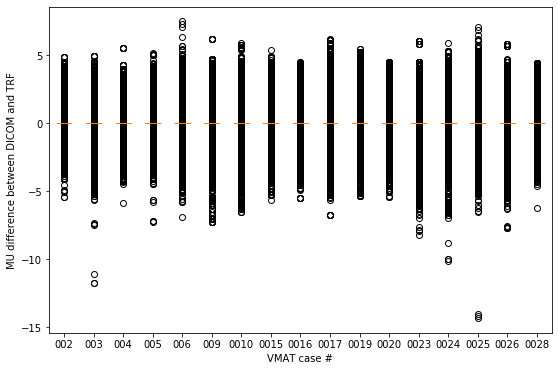

In [4]:
pt_id = ['002','003','004','005','006','009','0010','0015','0016','0017','0019','0020','0023','0024','0025','0026','0028']
DATA_path = 'C:/GitFolder/RL-Application-in-TPS/AUTO-PLANNING/AutoTemplateTuning/projects/sequencing prediction/DATA_/'
diff,diff_max,diff_var = [],[],[]
for item in pt_id:
    DICOM_MU = np.load(os.path.join(DATA_path,item + '_MU_density.npy'))
    TRF_MU = np.load(os.path.join(DATA_path,item + '_MU_density_trf.npy'))
    D = DICOM_MU - TRF_MU
    diff.append(D.flatten())
    diff_max.append(np.max(np.abs(D)))
    diff_var.append(np.std(np.abs(D)))

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(diff,patch_artist=True)
ax.set_xticklabels(pt_id)
ax.set_xlabel('VMAT case #')
ax.set_ylabel('MU difference between DICOM and TRF')
plt.show()

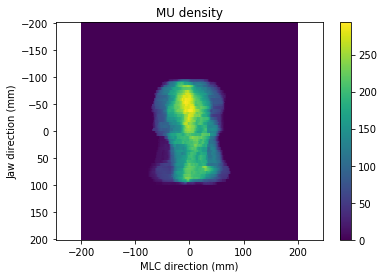

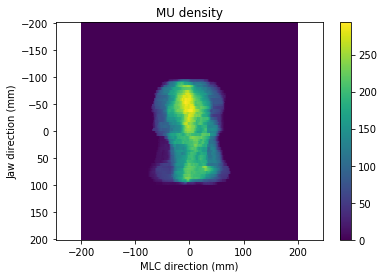

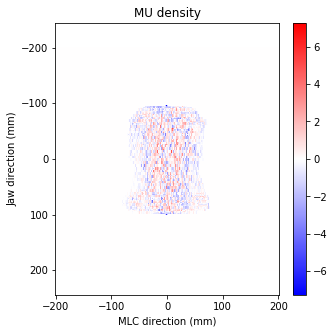

PLOT finished!


In [5]:
# show MU density of dicom, trf and difference
TRF_path = 'D:\\VM Settings\\XHTOMODATA RAW\\TRF\\005.trf'
DICOM_path = 'D:\\VM Settings\\XHTOMODATA RAW\\005\\005_VMATQATEST.dcm'
DICOM_MU_DENSITY = X.MU_Density_DICOM(DICOM_path) # DICOM path
# np.save(DATA_path + '005_MU_density.npy',DICOM_MU_DENSITY)
TRF_MU_DENSIT = X.MU_Density_TRF(TRF_path) # TRF path
# np.save(DATA_path + '005_MU_density_trf.npy',TRF_MU_DENSIT)
# display all
X.display_mu_density_and_difference()

### Calculate SSIM metrics for fluence map

In [10]:
def ssim(img1, img2):
    C1 = (0.01 * np.max(img1))**2
    C2 = (0.03 * np.max(img2))**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [11]:
SSIM, SSIM_mean = [],[]
path = 'C:\\GitFolder\\RL-Application-in-TPS\\AUTO-PLANNING\\AutoTemplateTuning\\projects\\sequencing prediction\\DATA_'
for item in pt_id:
    DICOM_MU_DENSITY = np.load(os.path.join(path,item+'_MU_density.npy'))
    TRF_MU_DENSIT = np.load(os.path.join(path,item+'_MU_density_trf.npy'))
    temp = calculate_ssim(DICOM_MU_DENSITY, TRF_MU_DENSIT)
    SSIM.append(temp)
    SSIM_mean.append(temp.mean())

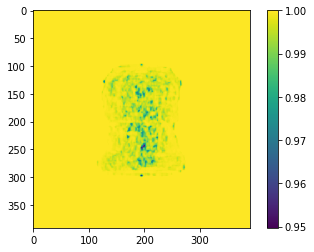

In [12]:
plt.imshow(SSIM[3])
plt.colorbar()

In [13]:
np.mean(SSIM_mean)

0.9988866733379272

### Calculate PSNR: Peak Signal-to-Noise Ratio

In [15]:
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(np.max(img1) / math.sqrt(mse))

In [16]:
PSNR, PSNR_mean = [],[]
path = 'C:\\GitFolder\\RL-Application-in-TPS\\AUTO-PLANNING\\AutoTemplateTuning\\projects\\sequencing prediction\\DATA_'
for item in pt_id:
    DICOM_MU_DENSITY = np.load(os.path.join(path,item+'_MU_density.npy'))
    TRF_MU_DENSIT = np.load(os.path.join(path,item+'_MU_density_trf.npy'))
    temp = calculate_psnr(DICOM_MU_DENSITY, TRF_MU_DENSIT)
    PSNR.append(temp)

In [17]:
PSNR

[55.38013993410182,
 54.18575969971375,
 55.20068385561055,
 57.017847393477474,
 52.83603432287116,
 53.84968157989722,
 53.31427396317025,
 55.5213817478755,
 54.79882256896195,
 52.579900592627105,
 53.053965985776905,
 53.959958299259895,
 55.48447992662689,
 55.54604774391262,
 55.02254367081566,
 54.09412648796297,
 55.781516111223716]